## TFRecordDataset

In [96]:
import torch
from torch.utils.data import DataLoader, Dataset
import tfrecord
from tfrecord.torch.dataset import TFRecordDataset

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [97]:
        
def remap( img, x, y):
    x, y = np.float32(x), np.float32(y)
    out = cv2.remap(img, x, y, cv2.INTER_LINEAR)  # INTER_LANCZOS4 INTER_CUBIC INTER_LINEAR
    return out

def cdi2fdi( u_cdi, v_cdi, delta=1):
    assert u_cdi.shape == v_cdi.shape
    # shape[0]:height, shape[1]:width
    y, x = np.meshgrid(np.arange(u_cdi.shape[0]), np.arange(u_cdi.shape[1]),indexing='ij')
    u_c, v_c = u_cdi/delta, v_cdi/delta
    
    # init fdi field for later process
    u_f = remap(u_c, x+0.5*u_c, y+0.5*v_c)
    v_f = remap(v_c, x+0.5*u_c, y+0.5*v_c)
    
    # solve 'Vcdi[x + 1/2Vfdi(x)] = Vfdi(x)' via iteration
    for _ in range(5):
        u_f = remap(u_c, x+0.5*u_f, y+0.5*v_f)
        v_f = remap(v_c, x+0.5*u_f, y+0.5*v_f)
    u_f, v_f = delta*u_f, delta*v_f
    return u_f, v_f

def cropImg( img, offset=10):
    """
    img: CxHxW
    """
    _, height, width = img.shape
    return img[:, offset:height-offset, offset:width-offset]


In [98]:
pathToTfrecord = './data/Test_Dataset_10Imgs_cylinder.tfrecord-00000-of-00001'
indexPath = './data/idx_files/Test_Dataset_10Imgs_cylinder.idx'
description = {"target":"byte",
               "label":"byte",
               "flow":"byte"}
imgShape = [2,256,256]
cropOffset = 10
to_fdi = False

def reshapeImage(img,imgShape,ifFlow=False):
    img = img.reshape(2,256,256)
    
    if ifFlow and to_fdi:
        ucdi = img[0]
        vcdi = img[1]
        img = cdi2fdi(ucdi,vcdi)
        img = np.stack(img,axis=0)
        print('before crop:img\'s shape:',img.shape)

    if cropOffset != 0:
        img = cropImg(img)
    return img
    
def decodeData(features):
    """
    https://stackoverflow.com/questions/40589499/what-do-the-signs-in-numpy-dtype-mean
    https://numpy.org/doc/stable/reference/generated/numpy.dtype.byteorder.html
    """
    features['target'] = reshapeImage(features['target'].view('<f4'),imgShape)
    features['flow'] = reshapeImage(features['flow'].view('<f4'),imgShape,ifFlow=True)
    features['label'] = features['label'].view('<f4')
    
    return features
               
testDataset = TFRecordDataset(pathToTfrecord, indexPath, description,
                              transform=decodeData)
testLoader = DataLoader(testDataset, batch_size=1,shuffle=False)

In [99]:
data = next(iter(testLoader))
for key in data.keys():
    print(data.get(key).shape)

imgs = data['target']
flow = data['flow']

torch.Size([1, 2, 236, 236])
torch.Size([1, 12])
torch.Size([1, 2, 236, 236])


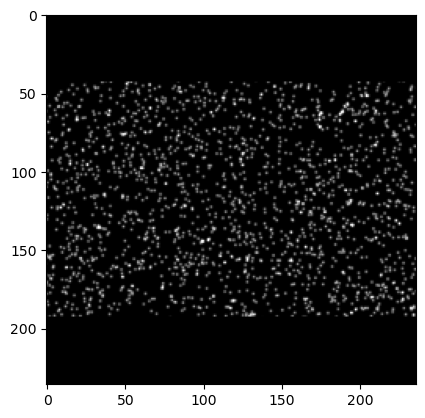

In [100]:
img1 = imgs[:,0,...]/255
img2 = imgs[:,1,...]/255

plt.imshow(img1.squeeze(0),cmap='gray')
plt.show()

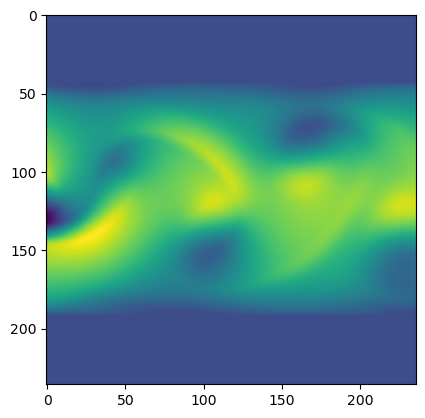

In [101]:
plt.imshow(flow[0,0,...])
plt.show()

## test nvidia-dali

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIGenericIterator
from nvidia.dali.plugin.pytorch import DALIClassificationIterator as PyTorchIterator
import nvidia.dali.tfrecord as tfrec

In [37]:
class TFRecordPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, num_gpus, shard_id, num_shards, tfrecord, tfrecord_idx, exec_pipelined=False, exec_async=False, is_shuffle=False, image_shape=[2,256,256], label_shape=[2,12], to_fdi=False):
        super(TFRecordPipeline, self).__init__(batch_size, num_threads, device_id, exec_pipelined=False, exec_async=False)
        self.input = ops.TFRecordReader(path = tfrecord, 
                                        index_path = tfrecord_idx,
                                        random_shuffle=is_shuffle,
                                        pad_last_batch = True,
                                        shard_id=shard_id,
                                        num_shards=num_shards,
                                        features = {"target" : tfrec.FixedLenFeature([], tfrec.string, ""),
                                                    "label": tfrec.FixedLenFeature([], tfrec.string,  ""),
                                                    "flow" : tfrec.FixedLenFeature([], tfrec.string, ""),
                                                   })
    
        self.decode = ops.PythonFunction(function=self.extract_view, num_outputs=1)
        self.reshape_image = ops.Reshape(shape=image_shape)
        self.reshape_label = ops.Reshape(shape=label_shape)
        
        self.to_fdi = to_fdi 

    def extract_view(self, data):
        ext_data = data.view('<f4')

        return ext_data

    def define_graph(self):
        inputs = self.input(name="Reader")
        images = self.reshape_image(self.decode(inputs['target']))
        labels = self.reshape_label(self.decode(inputs['label']))
        flows = self.reshape_image(self.decode(inputs['flow']))
        
        print(type(flows))

        return images, labels, flows

In [38]:
val_pipe = TFRecordPipeline(batch_size=1, num_threads=8, device_id=0, num_gpus=1,
                            tfrecord='./data/Test_Dataset_10Imgs_cylinder.tfrecord-00000-of-00001', tfrecord_idx='./data/idx_files/-Test_Dataset_10Imgs_cylinder.idx',
                            num_shards=1, shard_id=0,
                            is_shuffle=True, image_shape=[2, 256, 256], label_shape=[12, ], to_fdi=True)
val_pipe.build()
val_pii = DALIGenericIterator(val_pipe, ['target', 'label', 'flow'],
                              size=int(val_pipe.epoch_size("Reader") / 1),
                              last_batch_padded=True, fill_last_batch=False, auto_reset=True)

<class 'nvidia.dali.pipeline.DataNode'>


/home/wanxuan/miniconda3/envs/torch/lib/python3.10/site-packages/nvidia/dali/ops.py:866: DeprecationWarning: WARNING: `tfrecord_reader` is now deprecated. Use `readers.tfrecord` instead.
In DALI 1.0 all readers were moved into a dedicated :mod:`~nvidia.dali.fn.readers`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  op_instance = _OperatorInstance(inputs, self, **kwargs)
/home/wanxuan/miniconda3/envs/torch/lib/python3.10/site-packages/nvidia/dali/plugin/pytorch.py:181: Warning: Please do not use `fill_last_batch` and use `last_batch_policy`                            instead.
  _DaliBaseIterator.__init__(self,
/home/wanxuan/miniconda3/envs/torch/lib/python3.10/site-packages/nvidia/dali/plugin/base_iterator.py:192: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning 

In [12]:
sample = next(iter(val_pii))

sample = sample[0]
for key in sample.keys():
    print(sample.get(key).shape)

torch.Size([1, 12])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])


In [56]:
sample['flow'].type(torch.FloatTensor).dtype

torch.float32

In [63]:
sample['flow'].size()

torch.Size([1, 2, 256, 256])